In [31]:
# ===============================
# 🧠 HEART DISEASE DATA PREPROCESSING
# ===============================

# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Step 2: Load Dataset
data = pd.read_csv("heart_failure_rebalanced.csv")

# Remove unnamed columns (extra index columns from Excel)
data = data.drop(columns=[col for col in data.columns if "Unnamed" in col])

# Clean column names
data.columns = data.columns.str.strip()

# Step 3: Handle Missing Values
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())

# Step 4: One-Hot Encode Categorical Features
if 'Age Group' in data.columns:
    data = pd.get_dummies(data, columns=['Age Group'], drop_first=False)

# Step 5: Define Target Variable
target_col = 'Mortality'
y = data[target_col]

# Step 6: Select Top 20 Important Features (based on prior analysis)
top_20_features = [
    'Age Group_51-60', 'Age', 'chol', 'trestbps', 'oldpeak', 'ca',
    'thalach', 'C.P.K', 'BGR', 'Age Group_41-50', 'Follow.Up',
    'CK.MB', 'M.C.H', 'MONOCYTE', 'M.C.V', 'PLATELET_COUNT',
    'ESR', 'LYMPHO', 'WBC', 'num'
]

# Ensure all selected features exist in the dataset
available_features = [f for f in top_20_features if f in data.columns]
X = data[available_features]

# Step 7: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=available_features)

# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("\n✅ Data Preprocessing Completed Successfully!")
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")



✅ Data Preprocessing Completed Successfully!
Training set size: (79, 20)
Testing set size: (35, 20)


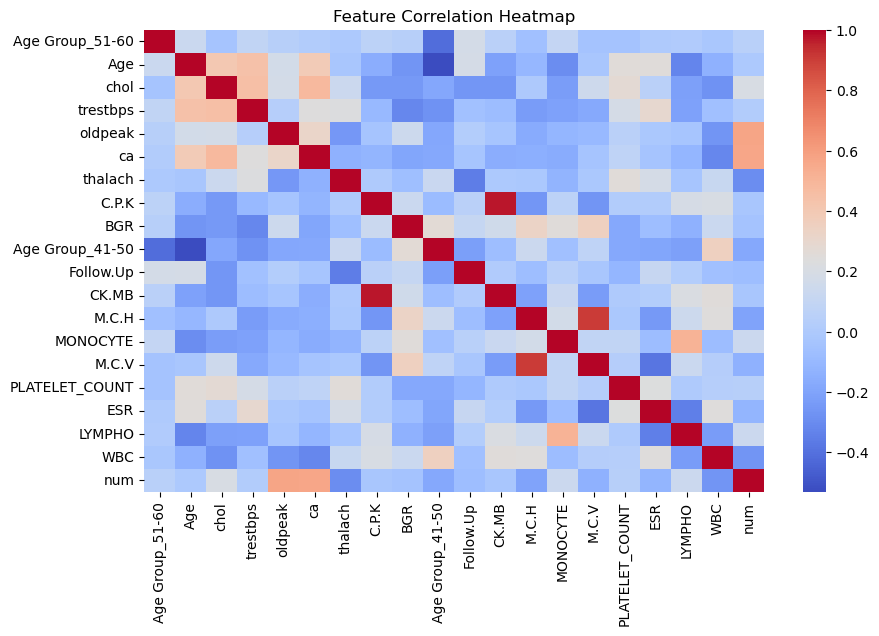

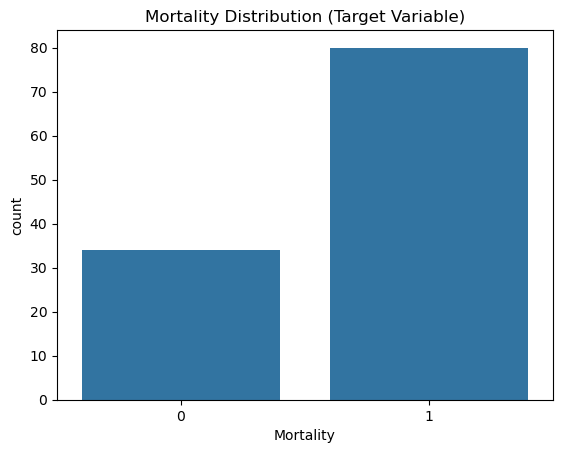

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Target Distribution
sns.countplot(x=y)
plt.title("Mortality Distribution (Target Variable)")
plt.show()




In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

🌲 Random Forest Accuracy: 0.829
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.91      0.84      0.88        25

    accuracy                           0.83        35
   macro avg       0.79      0.82      0.80        35
weighted avg       0.84      0.83      0.83        35

📈 Logistic Regression Accuracy: 0.771
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.84      0.84      0.84        25

    accuracy                           0.77        35
   macro avg       0.72      0.72      0.72        35
weighted avg       0.77      0.77      0.77        35



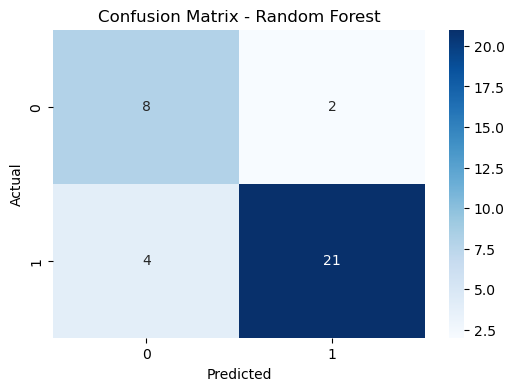

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Random Forest Evaluation
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("🌲 Random Forest Accuracy:", round(rf_acc, 3))
print(classification_report(y_test, rf_pred))

# Logistic Regression Evaluation
lr_pred = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print("📈 Logistic Regression Accuracy:", round(lr_acc, 3))
print(classification_report(y_test, lr_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


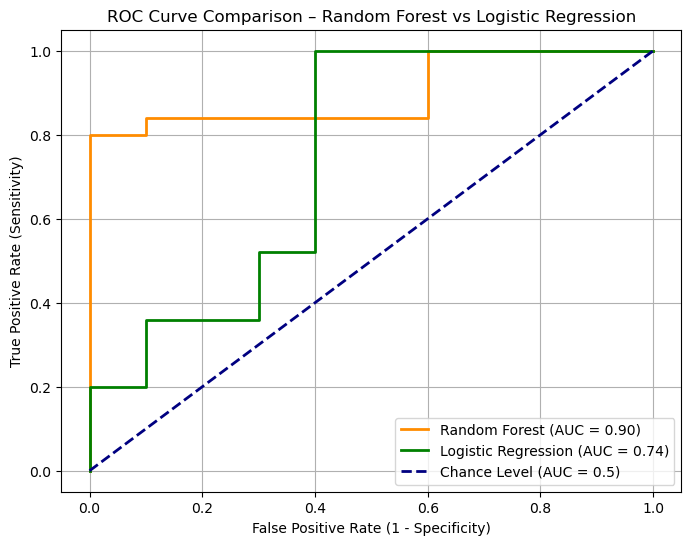

In [37]:
# ============================================
# 📉 STEP – ROC Curve for Random Forest & Logistic Regression
# ============================================
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# ---- Train Random Forest ----
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# ---- Train Logistic Regression ----
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

# ---- Compute ROC Curves and AUC ----
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)

auc_rf = auc(fpr_rf, tpr_rf)
auc_log = auc(fpr_log, tpr_log)

# ---- Plot Both ROC Curves ----
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2,
         label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_log, tpr_log, color='green', lw=2,
         label=f'Logistic Regression (AUC = {auc_log:.2f})')

# Baseline (Chance level)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Level (AUC = 0.5)')

# ---- Formatting ----
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve Comparison – Random Forest vs Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [43]:
# ============================================
# ⚙️ STEP 4 – TRAIN SVM CLASSIFIER
# ============================================

# Create SVM model (RBF kernel performs well on non-linear data)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

# Train
svm_model.fit(X_train, y_train)

print("✅ SVM Model Trained Successfully!")


✅ SVM Model Trained Successfully!


SVM Accuracy: 0.800
ROC-AUC Score: 0.804

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.88      0.84      0.86        25

    accuracy                           0.80        35
   macro avg       0.76      0.77      0.76        35
weighted avg       0.81      0.80      0.80        35



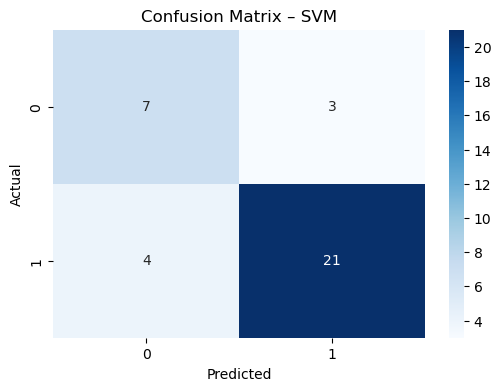

In [23]:
# ============================================
# 📈 STEP 5 – EVALUATE MODEL PERFORMANCE
# ============================================

# Predict
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
print(f"SVM Accuracy: {acc:.3f}")
print(f"ROC-AUC Score: {roc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


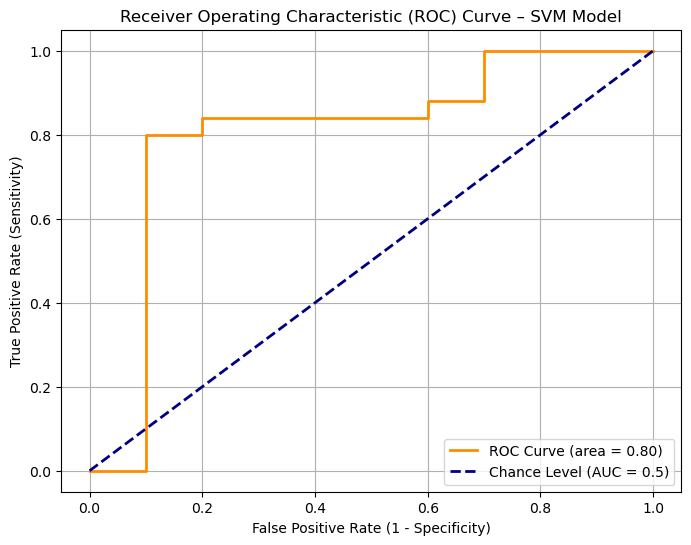

In [25]:
# ============================================
# 📉 STEP 6 – PLOT ROC CURVE
# ============================================
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Level (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve – SVM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
